# Multivariate Probabilistic Time Series Forecasting with Informer

Código baseado em: https://huggingface.co/blog/informer

In [ ]:
%pip install -q transformers datasets evaluate accelerate gluonts ujson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 984.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
from transformers.utils import send_example_telemetry

send_example_telemetry("multivariate_informer_notebook", framework="pytorch")

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.7 MB/s eta 0:00:00


In [ ]:
!pip install gpustat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.0 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.1.1-py3-none-any.whl size=26532 sha256=7454605d2c4ba61be5fad8aa29299861f369196cdf50b1eb69ca388545523252
  Stored in directory: /root/.cache/pip/wheels/ec/d7/80/a71ba3540900e1f276bcae685efd8e590c810d2108b95f1e47
Successfully built gpustat


## Load Dataset



In [ ]:
import psutil
memoria_usada = []
def capturar_uso_memoria():
    # Captura o uso de memória RAM atual
    uso_memoria = psutil.virtual_memory().used
    memoria_usada.append(uso_memoria)

# Chama a função para capturar o uso de memória



In [ ]:
import pandas as pd
# LSD https://drive.google.com/file/d/11Wv1SFE_O0dGeYMWEXQpGOyd11Z2v41J/view?usp=drive_link
#CEEI https://drive.google.com/file/d/1-O64qB-YGpzpJ3QmRHTb6MxcqZYZRMdC/view?usp=drive_link
# Carregar o CSV
df = pd.read_csv("https://docs.google.com/uc?export=download&id=1-O64qB-YGpzpJ3QmRHTb6MxcqZYZRMdC")

# Converter a coluna de datas para datetime
df['Data'] = pd.to_datetime(df['Data'])

# Definir o índice como a coluna de datas
df.set_index('Data', inplace=True)
df['item_id'] = df.index.astype(str)
df['categoria'] = df.groupby(df.index).ngroup()
# Criar um DataFrame para armazenar as características especificadas
data = {
    'start': [],
    'target': [],
    'feat_static_cat': [],
    'feat_dynamic_real': [],
    'item_id': []
}

# Iterar sobre as séries temporais no DataFrame
for item_id, group in df.groupby('item_id'):
    start = group.index[0]  # Obter a data de início da série temporal
    target = group['total_w'].values.astype('float32')  # Obter os valores de consumo como array de float32
    feat_static_cat = group['categoria'].iloc[0]  # Obter a categoria como identificador estático
    feat_dynamic_real = None  # Deixar como None, já que não temos features dinâmicas
    item_id = str(item_id)  # Converter o identificador para string

    # Adicionar os valores ao dicionário de dados
    data['start'].append(start)
    data['target'].append(target[0])
    data['feat_static_cat'].append(feat_static_cat)
    data['feat_dynamic_real'].append(feat_dynamic_real)
    data['item_id'].append(item_id)

# Criar o DataFrame com as características especificadas
df_final = pd.DataFrame(data)

print(df_final)


                   start        target  feat_static_cat feat_dynamic_real  \
0    2022-09-08 00:00:00  17639.914062                0              None   
1    2022-09-08 01:00:00  17591.212891                1              None   
2    2022-09-08 02:00:00  17771.755859                2              None   
3    2022-09-08 03:00:00  17665.738281                3              None   
4    2022-09-08 04:00:00  17753.679688                4              None   
...                  ...           ...              ...               ...   
8011 2023-08-07 19:00:00  18893.044922             8011              None   
8012 2023-08-07 20:00:00  19310.406250             8012              None   
8013 2023-08-07 21:00:00  18756.779297             8013              None   
8014 2023-08-07 22:00:00  19094.703125             8014              None   
8015 2023-08-07 23:00:00  19139.078125             8015              None   

                  item_id  
0     2022-09-08 00:00:00  
1     2022-09-08 01

In [ ]:
from datasets import Dataset, DatasetDict
import pandas as pd

# Converter o DataFrame para um Dataset
dataset = Dataset.from_pandas(df_final)

# Calcular o tamanho de cada conjunto de dados
total_size = len(dataset)
train_size = test_size = validation_size = total_size // 3

# Dividir o dataset em conjuntos de treinamento, teste e validação
train_dataset = dataset.select(range(train_size))
test_dataset = dataset.select(range(train_size, train_size + test_size))
validation_dataset = dataset.select(range(train_size + test_size, total_size))

# Criar listas de 'target' para cada conjunto de dados
train_target = [example['target'] for example in train_dataset]
test_target = [example['target'] for example in test_dataset]
validation_target = [example['target'] for example in validation_dataset]

# Converter a coluna 'start' de volta para datetime no estilo desejado
train_dataset = train_dataset.map(lambda example: {'start': pd.to_datetime(example['start'], unit='s'),
                                                   'target': train_target,
                                                   'feat_static_cat': [example['feat_static_cat']],
                                                   'feat_dynamic_real': example['feat_dynamic_real'],
                                                   'item_id': example['item_id']})

test_dataset = test_dataset.map(lambda example: {'start': pd.to_datetime(example['start'], unit='s'),
                                                 'target': test_target,
                                                 'feat_static_cat': [example['feat_static_cat']],
                                                 'feat_dynamic_real': example['feat_dynamic_real'],
                                                 'item_id': example['item_id']})

validation_dataset = validation_dataset.map(lambda example: {'start': pd.to_datetime(example['start'], unit='s'),
                                                             'target': validation_target,
                                                             'feat_static_cat': [example['feat_static_cat']],
                                                             'feat_dynamic_real': example['feat_dynamic_real'],
                                                             'item_id': example['item_id']})

# Criar o DatasetDict com os conjuntos de dados divididos
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'validation': validation_dataset
})

print(len(dataset_dict['train']), len(dataset_dict['test']), len(dataset_dict['validation']))


Map:   0%|          | 0/2672 [00:00<?, ? examples/s]

Map:   0%|          | 0/2672 [00:00<?, ? examples/s]

Map:   0%|          | 0/2672 [00:00<?, ? examples/s]

2672 2672 2672


In [ ]:
from datasets import load_dataset

#dataset = load_dataset("monash_tsf", "traffic_hourly")
dataset = dataset_dict

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 2672
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 2672
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 2672
    })
})

In [ ]:
train_example = dataset["train"][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [ ]:
print(train_example["start"])
print(len(train_example["target"]))

2022-09-08 00:00:00
2672


In [ ]:
validation_example = dataset["validation"][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [ ]:
len(train_example["target"])

2672

In [ ]:
len(
    dataset["validation"][0]["target"]
)

2672

In [ ]:
freq = "1H"
prediction_length = 48

#assert len(train_example["target"]) + prediction_length == len(
 #   dataset["validation"][0]["target"]
#)

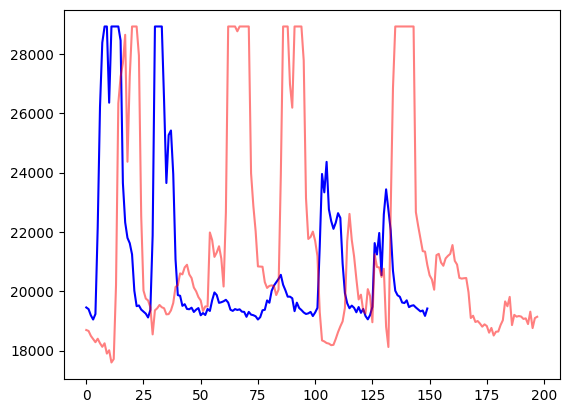

In [ ]:
import matplotlib.pyplot as plt

num_of_samples = 150

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], color="blue")
axes.plot(
    validation_example["target"][-num_of_samples - prediction_length :],
    color="red",
    alpha=0.5,
)

plt.show()

Let's split up the data:

In [ ]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

## Update `start` to `pd.Period`


In [ ]:
from functools import lru_cache

import pandas as pd
import numpy as np


@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [ ]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [ ]:
import numpy as np
from gluonts.dataset.common import ListDataset

# Supondo que você tenha uma lista de séries temporais em train_data

# Iterar sobre os dados e ajustar as formas dos campos necessários
for item in train_dataset:
    item["target"] = np.expand_dims(item["target"], axis=0)  # Adicionar dimensão extra ao campo "target"
    item["target"] = np.expand_dims(item["target"], axis=0)  # Adicionar dimensão extra ao campo "target"
    item["feat_static_cat"] = np.expand_dims(item["feat_static_cat"], axis=0)  # Adicionar dimensão extra ao campo "feat_static_cat"

# Criar um ListDataset com os dados modificados
train_dataset = ListDataset(train_dataset, freq="H")


In [ ]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates
)

multi_variate_train_dataset = train_grouper(train_dataset)


In [ ]:
multi_variate_test_dataset = test_grouper(test_dataset)

In [ ]:
multi_variate_train_example = multi_variate_train_dataset[0]
print(
    f"multi_variate_train_example['target'].shape = {multi_variate_train_example['target'].shape}"
)

multi_variate_train_example['target'].shape = (2672, 5343)


## Define the model



In [ ]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


In [ ]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function hour_of_day at 0x7cea7a588280>, <function day_of_week at 0x7cea7b372f80>, <function day_of_month at 0x7cea7b3736d0>, <function day_of_year at 0x7cea7b373eb0>]


In [ ]:
from pandas.core.arrays.period import period_array

timestamp = pd.Period("2022-09-08 00:00:00", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'hour_of_day': array([-0.5]), 'day_of_week': array([0.]), 'day_of_month': array([-0.26666667]), 'day_of_year': array([0.18493151])}


In [ ]:
from transformers import InformerConfig, InformerForPrediction

config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = InformerForPrediction(config)

In [ ]:
model.config.distribution_output

'student_t'

## Define Transformations



In [ ]:
from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [ ]:
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

## Define `InstanceSplitter`



In [ ]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

## Create DataLoaders



In [ ]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [ ]:
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [ ]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [ ]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=32,
)

In [ ]:
train_dataloader

In [ ]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 264, 5]) torch.FloatTensor
past_values torch.Size([256, 264, 2672]) torch.FloatTensor
past_observed_mask torch.Size([256, 264, 2672]) torch.FloatTensor
future_time_features torch.Size([256, 48, 5]) torch.FloatTensor
future_values torch.Size([256, 48, 2672]) torch.FloatTensor
future_observed_mask torch.Size([256, 48, 2672]) torch.FloatTensor


## Forward pass


In [ ]:
train_dataloader

In [ ]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [ ]:
print("Loss:", outputs.loss.item())

Loss: 30809.640625


## Train the Model



In [ ]:
from accelerate import Accelerator
from torch.optim import AdamW

epochs = 15 #era 25 mas quebrou no tempo max do colab
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):

    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss
        capturar_uso_memoria()
        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()
        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())

30814.603515625
25860.84375
24908.138671875
24819.904296875
24541.384765625
24291.6875
24196.341796875
24252.994140625
24006.751953125
24119.2109375
23692.046875
23936.568359375
23622.150390625
23555.009765625
23544.53125


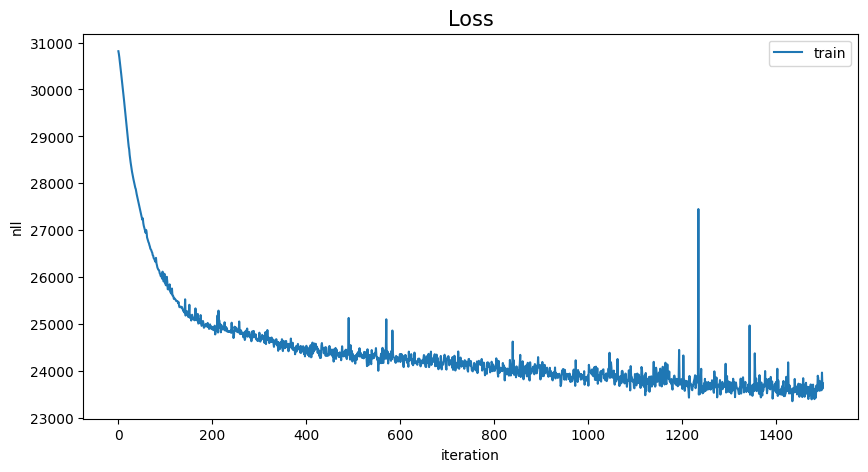

In [ ]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

In [ ]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    capturar_uso_memoria()
    forecasts_.append(outputs.sequences.cpu().numpy())

In [ ]:
forecasts_[0].shape

(1, 100, 48, 2672)

In [ ]:
forecasts = np.vstack(forecasts_)
print(forecasts.shape)

(1, 100, 48, 2672)


In [ ]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])
    capturar_uso_memoria()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from gluonts.time_feature import get_seasonality
from evaluate import load

def calculate_metrics(forecasts, test_dataset, prediction_length, freq):
    mase_metric = load("evaluate-metric/mase")
    smape_metric = load("evaluate-metric/smape")

    forecast_median = np.median(forecasts, 1).squeeze(0).T

    rmse_metrics = []
    mse_metrics = []
    mae_metrics = []
    mape_metrics = []
    r2_metrics = []
    mase_metrics = []
    smape_metrics = []

    for item_id, ts in enumerate(test_dataset):
        forecast_samples = forecast_median[item_id]
        ground_truth = ts["target"][-prediction_length:]

        # RMSE
        rmse = np.sqrt(mean_squared_error(ground_truth, forecast_samples))
        rmse_metrics.append(rmse)

        # MSE
        mse = mean_squared_error(ground_truth, forecast_samples)
        mse_metrics.append(mse)

        # MAE
        mae = mean_absolute_error(ground_truth, forecast_samples)
        mae_metrics.append(mae)

        # MAPE
        mape = np.mean(np.abs((ground_truth - forecast_samples) / ground_truth)) * 100
        mape_metrics.append(mape)

        # R2
        r2 = r2_score(ground_truth, forecast_samples)
        r2_metrics.append(r2)

        # MASE
        training_data = ts["target"][:-prediction_length]
        mase = mase_metric.compute(
            predictions=forecast_samples,
            references=np.array(ground_truth),
            training=np.array(training_data),
            periodicity=get_seasonality(freq),
        )
        mase_metrics.append(mase["mase"])

        # sMAPE
        smape = smape_metric.compute(
            predictions=forecast_samples,
            references=np.array(ground_truth),
        )
        smape_metrics.append(smape["smape"])

    return (
        np.mean(rmse_metrics),
        np.mean(mse_metrics),
        np.mean(mae_metrics),
        np.mean(mape_metrics),
        np.mean(r2_metrics),
        np.mean(mase_metrics),
        np.mean(smape_metrics),
    )

# Example usage
# Assume forecasts, test_dataset, prediction_length, and freq are already defined
rmse, mse, mae, mape, r2, mase, smape = calculate_metrics(forecasts, test_dataset, prediction_length, freq)
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)
print("R2:", r2)
print("MASE:", mase)
print("sMAPE:", smape)
print("Memoria RAM: ",max(memoria_usada))

RMSE: 5146.6808977918845
MSE: 26544774.969540674
MAE: 4084.583738559258
MAPE: 16.19400353379889
R2: -0.22473398629754238
MASE: 2.2735656179418147
sMAPE: 0.17592041388664026
Memoria RAM:  10244640768
